# OpenCV for Machine Learning

In [112]:
# enable showing matplotlib image inline
%matplotlib inline

# const variables
IMG = "./images/birds.JPG"
IMG_FOR_FILTER = "./images/charadrius-melodus.jpg"
IMG_FOR_CONTOUR = "./images/airplane.PNG"
IMG_FACE = "./images/face.PNG"
CASCADE_DIR = "./data"

# import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# global functions
def to_matplotlib_format(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def imshow_before_after(path_or_img, func, before_as_gray=False, after_as_gray=False):
    before = path_or_img if isinstance(path_or_img, np.ndarray) else cv2.imread(path_or_img)
    after = func(path_or_img)
    
    def imshow(img, as_gray):
        if as_gray:
            grayed = img
            if len(img.shape) > 2:  # check color channels
                grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            plt.imshow(grayed, cmap="gray")
        else:
            plt.imshow(to_matplotlib_format(img))
        plt.xticks([]), plt.yticks([])
        
    fig = plt.figure(figsize=(16, 12))
    plt.subplot(121)
    imshow(before, before_as_gray)
    plt.subplot(122)
    imshow(after, after_as_gray)
    plt.show()

## GrayScale


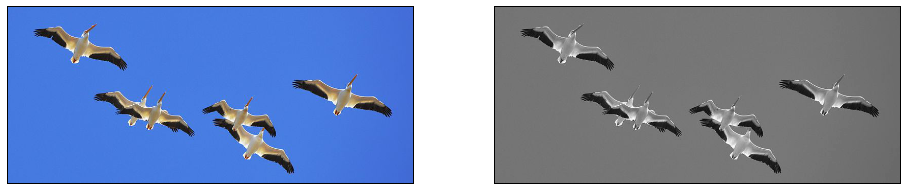

In [3]:
def to_grayscale(path):
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayed


imshow_before_after(IMG, to_grayscale, after_as_gray=True)


## Threshold

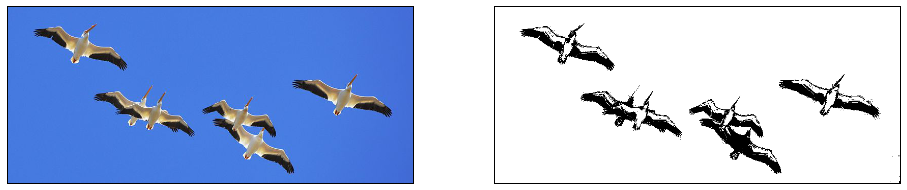

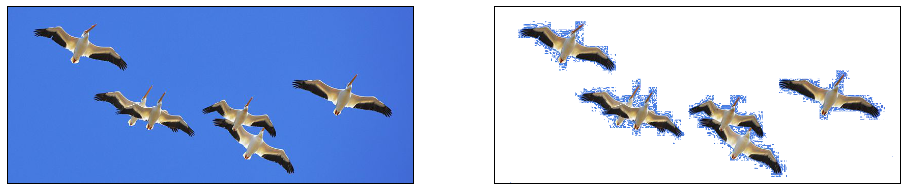

In [4]:
def binary_threshold(path_or_img, back_thresh, fore_thresh, maxValue):
    img = path_or_img if isinstance(path_or_img, np.ndarray) else cv2.imread(path_or_img)
    grayed = img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    th, drop_back = cv2.threshold(grayed, back_thresh, maxValue, cv2.THRESH_BINARY)
    th, clarify_born = cv2.threshold(grayed, fore_thresh, maxValue, cv2.THRESH_BINARY_INV)
    
    merged = np.minimum(drop_back, clarify_born)
    return merged


def mask_blue(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    blue_min = np.array([100, 170, 200], np.uint8)
    blue_max = np.array([120, 180, 255], np.uint8)
    
    blue_region = cv2.inRange(hsv, blue_min, blue_max)
    white = np.full(img.shape, 255, dtype=img.dtype)
    background = cv2.bitwise_and(white, white, mask=blue_region)  # detected blue area becomes white
    
    inv_mask = cv2.bitwise_not(blue_region)  # make mask for not-blue area
    extracted = cv2.bitwise_and(img, img, mask=inv_mask)
    
    masked = cv2.add(extracted, background)
    
    return masked


binary_threshold_for_birds = lambda im: binary_threshold(im, back_thresh=105, fore_thresh=145, maxValue=255)


imshow_before_after(IMG, binary_threshold_for_birds , after_as_gray=True)
imshow_before_after(IMG, mask_blue)

## Filter


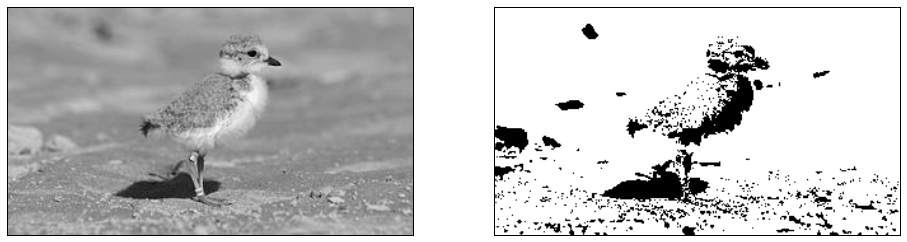

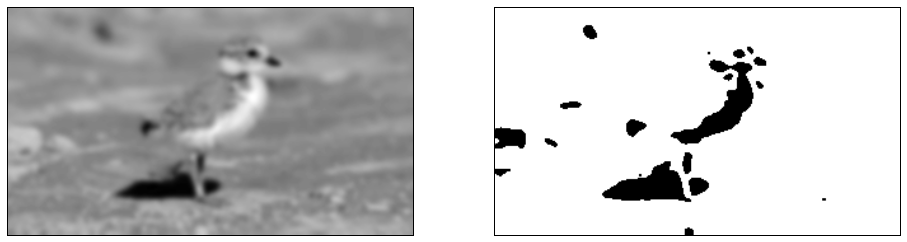

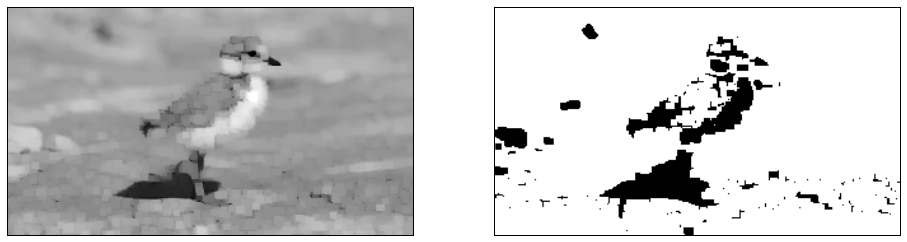

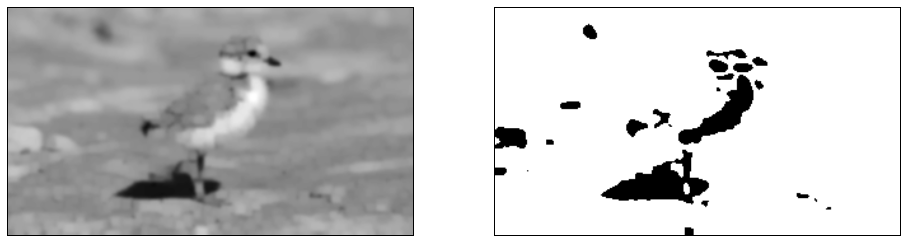

In [5]:
def clarify_contour(grayed, dark_line_thresh, light_line_thresh, drop_thresh):
    
    th, d_lined = cv2.threshold(grayed, dark_line_thresh, 255, cv2.THRESH_BINARY)
    th, l_lined = cv2.threshold(grayed, light_line_thresh, 255, cv2.THRESH_BINARY_INV)
    th, dropped = cv2.threshold(grayed, drop_thresh, 255, cv2.THRESH_BINARY)
    
    #plt.imshow(d_lined, cmap="gray")
    #plt.imshow(l_lined, cmap="gray")
    #plt.imshow(dropped, cmap="gray")
    
    merged = np.minimum(d_lined, l_lined, dropped)
    return merged


clarify_img_for_filter = lambda im: clarify_contour(im, 100, 150, 135)


def show_filter_effect(path, *filter_funcs):
    before = to_grayscale(path)
    imshow_before_after(before, clarify_img_for_filter, before_as_gray=True, after_as_gray=True)
    
    for f in filter_funcs:
        filtered = f(before)
        imshow_before_after(filtered, clarify_img_for_filter, before_as_gray=True, after_as_gray=True)


def blur(img):
    filtered = cv2.GaussianBlur(img, (11, 11), 0)
    return filtered


def morph(img):
    kernel = np.ones((3, 3),np.uint8)
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
    return opened


def morph_and_blur(img):
    kernel = np.ones((3, 3),np.uint8)
    m = cv2.GaussianBlur(img, (3, 3), 0)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=2)
    m = cv2.GaussianBlur(m, (5, 5), 0)
    return m

show_filter_effect(IMG_FOR_FILTER, blur, morph, morph_and_blur)


## Contour

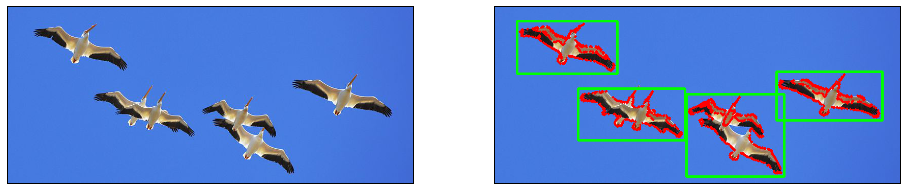

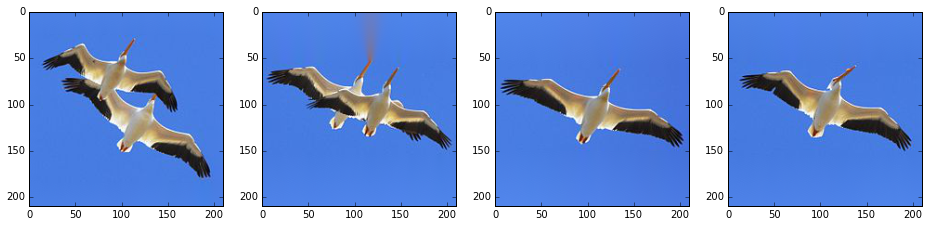

In [18]:
def resize_image(img, size):
    # size is enough to img
    img_size = img.shape[:2]
    if img_size[0] > size[1] or img_size[1] > size[0]:
        raise Exception("img is larger than size")
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img
        
    # filling
    mask = np.full(size, 255, dtype=np.uint8)
    mask[row:(row + img.shape[0]), col:(col + img.shape[1])] = 0
    filled = cv2.inpaint(resized, mask, 3, cv2.INPAINT_TELEA)    
    
    return filled


def padding_position(x, y, w, h, p):
    return x - p, y - p, w + p * 2, h + p * 2


def detect_contour(path, min_size):
    contoured = cv2.imread(path)
    forcrop = cv2.imread(path)

    # make binary image
    birds = binary_threshold_for_birds(path)
    birds = cv2.bitwise_not(birds)
    
    # detect contour
    im2, contours, hierarchy = cv2.findContours(birds, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    crops = []
    # draw contour
    for c in contours:
        if cv2.contourArea(c) < min_size:
            continue
        
        # rectangle area
        x, y, w, h = cv2.boundingRect(c)
        x, y, w, h = padding_position(x, y, w, h, 5)
        
        # crop the image
        cropped = forcrop[y:(y + h), x:(x + w)]
        cropped = resize_image(cropped, (210, 210))
        crops.append(cropped)
        
        # draw contour
        cv2.drawContours(contoured, c, -1, (0, 0, 255), 3)  # contour
        cv2.rectangle(contoured, (x, y), (x + w, y + h), (0, 255, 0), 3)  #rectangle contour
                
    return contoured, crops


def show_contour(path):
    imshow_before_after(path, lambda p: detect_contour(p, 50)[0])
    _, crops = detect_contour(path, 50)
    
    fig = plt.figure(figsize=(16, 12))
    for i, c in enumerate(crops):
        plt.subplot(141 + i)
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
    plt.show()
    
show_contour(IMG)

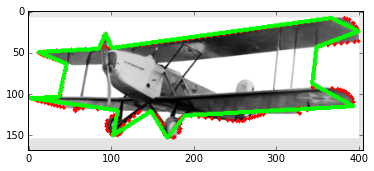

In [141]:
def various_contours(path):
    color = cv2.imread(path)
    grayed = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(grayed, 218, 255, cv2.THRESH_BINARY)
    inv = cv2.bitwise_not(binary)    
    _, contours, _ = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        if cv2.contourArea(c) < 90:
            continue
        
        epsilon = 0.01 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        cv2.drawContours(color, c, -1, (0, 0, 255), 3)
        cv2.drawContours(color, [approx], -1, (0, 255, 0), 3)
        
    plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))
    
various_contours(IMG_FOR_CONTOUR)

## Object Detection

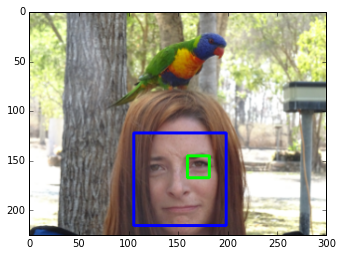

In [309]:
def face_detection(path):
    face_cascade = cv2.CascadeClassifier(CASCADE_DIR + "/haarcascade_frontalface_default.xml")
    eye_cascade = cv2.CascadeClassifier(CASCADE_DIR + "/haarcascade_eye.xml")
    
    img = cv2.imread(path)
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(grayed, 1.3, 5)
    for (x, y, w, h) in faces:
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        roi_gray = grayed[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex,ey), (ex + ew, ey + eh), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

face_detection(IMG_FACE)